# Customer Churn Telecom

Customer Churn (ou Rotatividade de Clientes, em uma tradução livre) refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da receita. Portanto, é muito importante prever os usuários que provavelmente abandonarão o relacionamento comercial e os fatores que afetam as decisões do cliente.

Neste projeto, o objetivo é prever o Customer Churn em uma Operadora de Telecom.

## Modelagem Preditiva

O objetivo final do projeto é construir um modelo preditivo para o Churn da empresa de Telecom. Após Análise Exploratória e Pré-Processamento, chegou a hora de construir o modelo de Machine Learning e avaliar sua performance. Nosso objetivo é atingir um F1-Score Macro de pelo menos 95%.

In [183]:
# Imports da biblioteca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [43]:
train_data = pd.read_csv("dados_treino_preproc.csv")
test_data = pd.read_csv("dados_teste_preproc.csv")

## Definição dos dados de entrada e saída

Para os primeiros modelos, não serão consideradas as variáveis criadas na Engenharia de Atributos

In [90]:
y_train, y_test = train_data['churn'], test_data['churn']
X_train, X_test = train_data.drop(columns = ['churn', 'special_plan', 'old_account']), test_data.drop(columns = ['churn', 'special_plan', 'old_account'])

## Função para treinar e avaliar modelos

In [91]:
def train_n_score_model(modelo, X_train, y_train, X_test, y_test):
    # Treinamento do modelo
    modelo.fit(X_train, y_train)
    
    # Previsões com modelo treinado
    y_pred = modelo.predict(X_test)
    
    # Matriz de confusão
    print('Matriz de confusão\n')
    print(confusion_matrix(y_test, y_pred))
    
    # Classificatin Report
    print('\n', classification_report(y_test, y_pred))

## Modelo 1 (Base) - Regressão Logística

In [92]:
modelo1 = LogisticRegression(max_iter=1000)

train_n_score_model(modelo1, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1413   30]
 [ 182   42]]

               precision    recall  f1-score   support

           0       0.89      0.98      0.93      1443
           1       0.58      0.19      0.28       224

    accuracy                           0.87      1667
   macro avg       0.73      0.58      0.61      1667
weighted avg       0.85      0.87      0.84      1667



O modelo base tem uma boa acurácia, 87%, porém observando a matriz de confusão e as métricas por classe, vê-se que o desbalanceamento de classe deixou o modelo enviesado.

## Modelo 2 - Regressão Logística com balanceamento dos pesos de classe

In [93]:
modelo2 = LogisticRegression(max_iter=1000, class_weight='balanced')

train_n_score_model(modelo2, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1099  344]
 [  41  183]]

               precision    recall  f1-score   support

           0       0.96      0.76      0.85      1443
           1       0.35      0.82      0.49       224

    accuracy                           0.77      1667
   macro avg       0.66      0.79      0.67      1667
weighted avg       0.88      0.77      0.80      1667



Com o segundo modelo, a acurácia caiu para 77%, porém as métricas por classe melhoraram um pouco. Porém a performance ainda está bem longe do ideal.

## Modelo 3 - Regressão Logística com Grid Search para pesos de classe

Pode-se testar um GridSearch com diferentes pesos para as classes para tentar encontrar o melhor valor. A métrica de avaliação utilizada será o F1-Score pois representa um melhor equilíbrio entre as previsões das classes

In [106]:
# Definindo diferentes valores de peso para classe
weights = np.linspace(0.0,0.99,200)

# Criando um dicionário para o Grid-Search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# GridSearch
modelo3 = GridSearchCV(estimator= LogisticRegression(max_iter=1000), 
                                  param_grid= param_grid,
                                  cv=5, 
                                  n_jobs=-1, 
                                  scoring='f1', 
                                  verbose=2)

In [107]:
train_n_score_model(modelo3, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Matriz de confusão

[[1233  210]
 [  87  137]]

               precision    recall  f1-score   support

           0       0.93      0.85      0.89      1443
           1       0.39      0.61      0.48       224

    accuracy                           0.82      1667
   macro avg       0.66      0.73      0.69      1667
weighted avg       0.86      0.82      0.84      1667



In [108]:
# Melhores parâmetros
modelo3.best_params_

{'class_weight': {0: 0.20894472361809047, 1: 0.7910552763819095}}

Com o terceiro modelo, o F1-Score aumentou em 2% e a acurácia em mais 5%. Os pesos ideias para as classes são 20/80.

## Modelo 3 (Retreino) - Logistic Regression com Feature Selection

Será testado o modelo retreinado, incluindo as variáveis criadas na Feature Selection, mas removendo as variáveis usadas para criar as novas.

In [158]:
X_train, X_test = train_data.drop(columns = ['churn', 'international_plan', 'voice_mail_plan', 'account_length']), \
                    test_data.drop(columns = ['churn', 'international_plan', 'voice_mail_plan', 'account_length'])

In [159]:
train_n_score_model(modelo3, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Matriz de confusão

[[1178  265]
 [  85  139]]

               precision    recall  f1-score   support

           0       0.93      0.82      0.87      1443
           1       0.34      0.62      0.44       224

    accuracy                           0.79      1667
   macro avg       0.64      0.72      0.66      1667
weighted avg       0.85      0.79      0.81      1667



O resultado foi muito próximo ao obtido anteriormente. A acurácia diminuiu um pouco mas o F1-Score Macro aumentou.

## Modelo 4 - Decision Tree

In [161]:
modelo4 = DecisionTreeClassifier()

train_n_score_model(modelo4, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1331  112]
 [  96  128]]

               precision    recall  f1-score   support

           0       0.93      0.92      0.93      1443
           1       0.53      0.57      0.55       224

    accuracy                           0.88      1667
   macro avg       0.73      0.75      0.74      1667
weighted avg       0.88      0.88      0.88      1667



Todas as métricas do modelo Decision Tree foram melhores que o modelo de Regressão Logística. Pode-se tentar utilizar um Random Forest.

## Modelo 5 - Random Forest

In [164]:
modelo5 = RandomForestClassifier()

train_n_score_model(modelo5, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1438    5]
 [ 107  117]]

               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1443
           1       0.96      0.52      0.68       224

    accuracy                           0.93      1667
   macro avg       0.94      0.76      0.82      1667
weighted avg       0.93      0.93      0.92      1667



O modelo Random Forest teve performance muito boa, com acurácia acima de 93% e F1-Score Macro de 82%.

## Importância das Features com Random Forest


In [166]:
# Extrai a importância
feature_importance = modelo5.feature_importances_
feature_names = modelo5.feature_names_in_

# Dicionário de importâncias
importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Constrói um DataFrame a partir do dicionário
df_imp = pd.DataFrame(importance_dict, index=['Feature Importance'])

# Transpõe o Dataframe
df_imp = df_imp.T

# Mostra o resultado final
df_imp

,Feature Importance
state,0.034868
number_vmail_messages,0.046768
total_day_minutes,0.158646
total_day_calls,0.044928
total_day_charge,0.155529
total_eve_minutes,0.083134
total_eve_calls,0.038292
total_eve_charge,0.076169
total_night_minutes,0.048979
total_night_calls,0.041905


In [167]:
plot = df_imp.sort_values(ascending=False, by=['Feature Importance'])

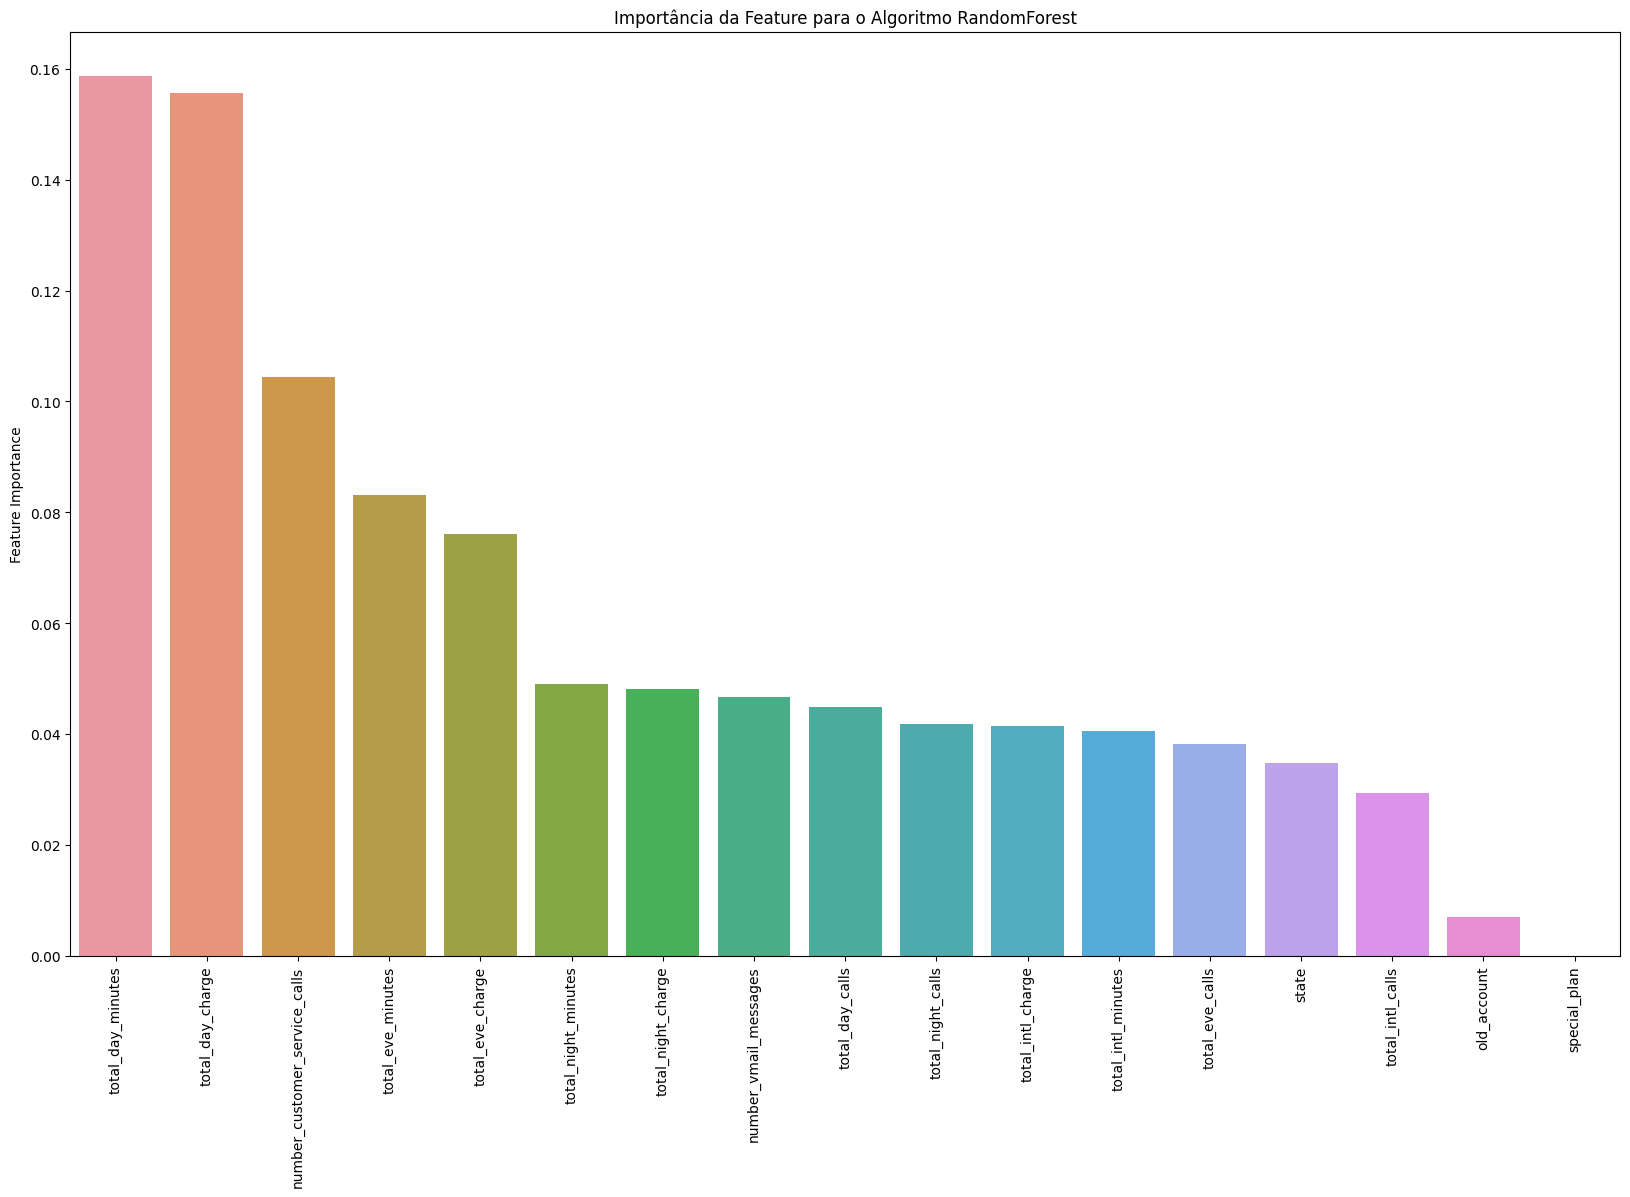

In [177]:
plt.figure(figsize=(20,12))
sns.barplot(data = plot, x=plot.index, y = 'Feature Importance')
plt.title('Importância da Feature para o Algoritmo RandomForest')
plt.xticks(rotation = 90);

As variáveis criadas na Engenharia de Atributos são as com menor importância. Elas serão removida do modelo. Pode-se testar se as variáveis originais são mais úteis na predição.

In [175]:
X_train, X_test = train_data.drop(columns = ['churn', 'special_plan', 'old_account']), \
                    test_data.drop(columns = ['churn', 'special_plan', 'old_account'])

In [176]:
train_n_score_model(modelo5, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1441    2]
 [  66  158]]

               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1443
           1       0.99      0.71      0.82       224

    accuracy                           0.96      1667
   macro avg       0.97      0.85      0.90      1667
weighted avg       0.96      0.96      0.96      1667



Com as variáveis originais, o modelo alcançou 90% de F1 Score Macro.

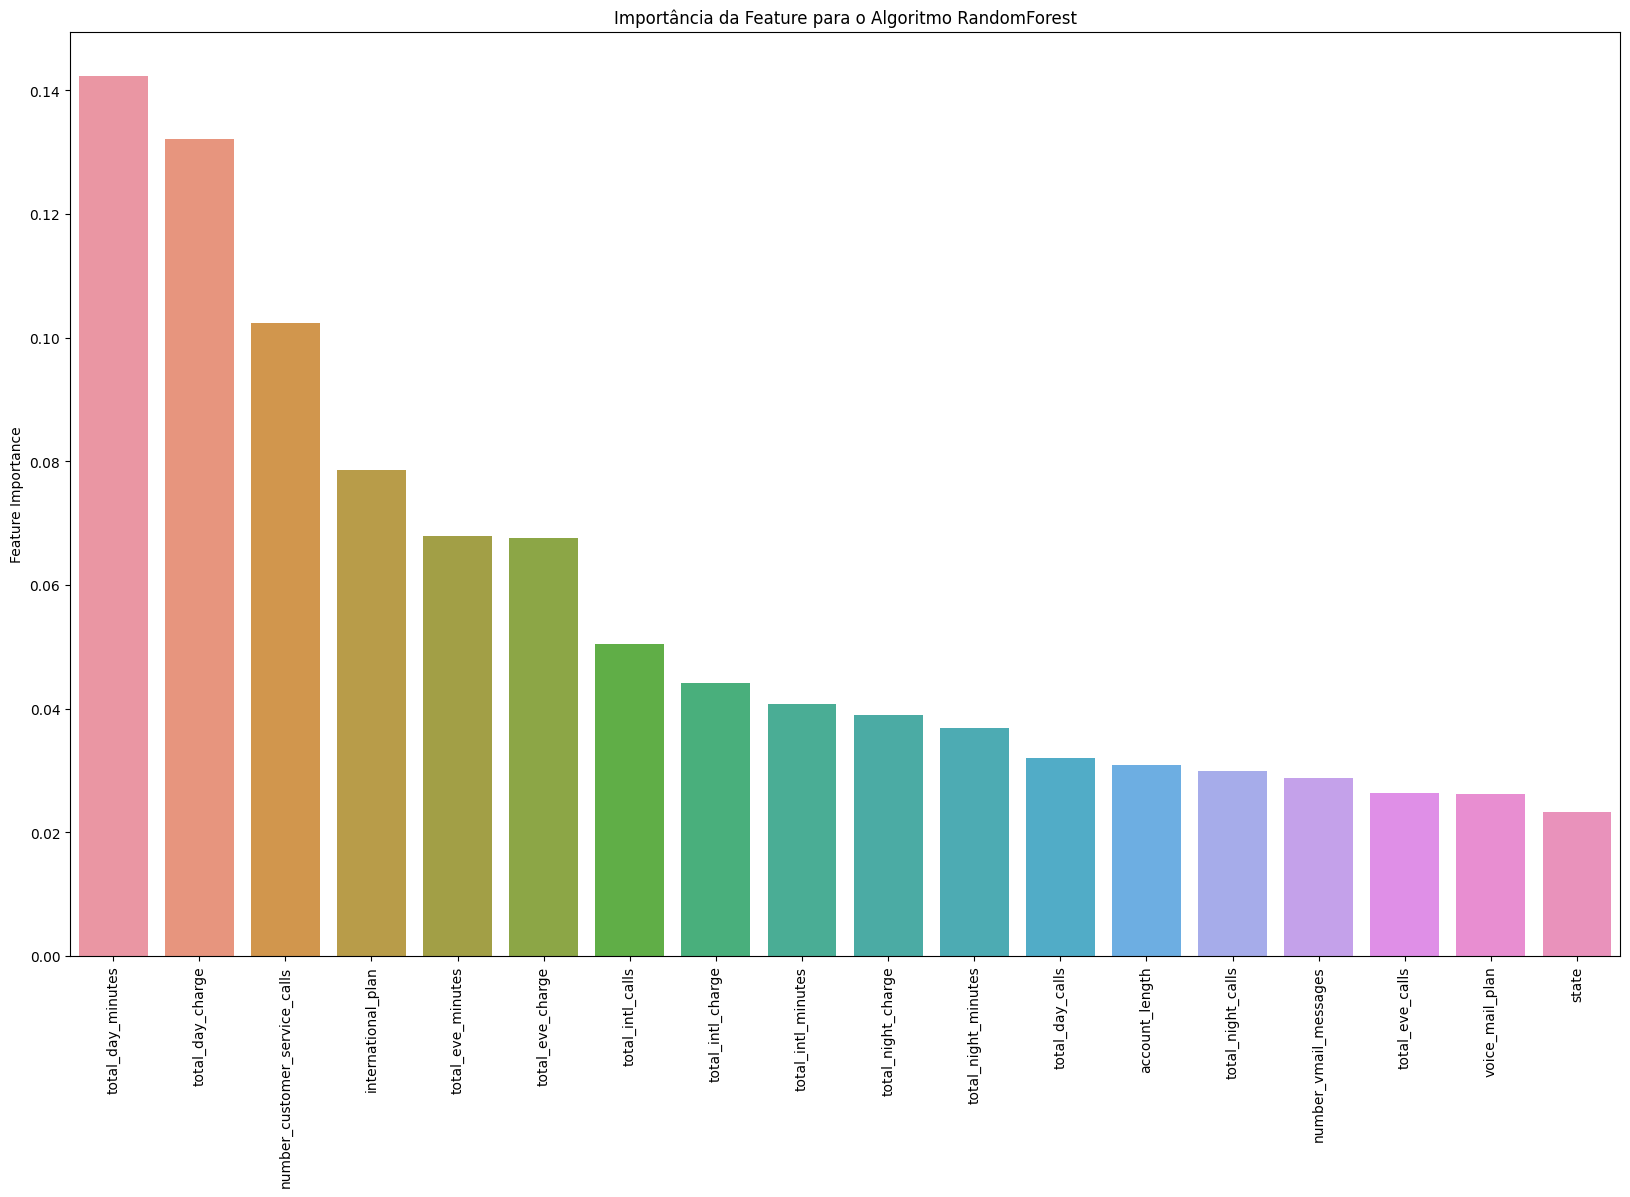

In [178]:
# Extrai a importância
feature_importance = modelo5.feature_importances_
feature_names = modelo5.feature_names_in_

# Dicionário de importâncias
importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Constrói um DataFrame a partir do dicionário
df_imp = pd.DataFrame(importance_dict, index=['Feature Importance'])

# Transpõe o Dataframe
df_imp = df_imp.T

# Mostra o resultado final
df_imp

# Objeto plot
plot = df_imp.sort_values(ascending=False, by=['Feature Importance'])

# Gráfico
plt.figure(figsize=(20,12))
sns.barplot(data = plot, x=plot.index, y = 'Feature Importance')
plt.title('Importância da Feature para o Algoritmo RandomForest')
plt.xticks(rotation = 90);

A variável international_plan é a quarta mais importante para as previsões, já a variável voice_mail plan é a segunda menos importante. Por hora, todas as variáveis serão mantidas no modelo.

## Modelo 6 - Random Forest com Otimização de Hiperparâmetros

In [180]:
# Criando um dicionário para o Grid-Search
param_grid = {'n_estimators': range(100, 600, 100),
              'criterion': ['gini', 'entropy'],
              'max_depth': range(4,10),
              'bootstrap': [True, False]}

# GridSearch
modelo6 = GridSearchCV(estimator= RandomForestClassifier(), 
                                  param_grid= param_grid,
                                  cv=5, 
                                  n_jobs=-1, 
                                  scoring='f1', 
                                  verbose=2)

In [181]:
train_n_score_model(modelo6, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Matriz de confusão

[[1440    3]
 [  66  158]]

               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1443
           1       0.98      0.71      0.82       224

    accuracy                           0.96      1667
   macro avg       0.97      0.85      0.90      1667
weighted avg       0.96      0.96      0.96      1667



In [182]:
modelo6.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 9,
 'n_estimators': 400}

A otimização de hiperparâmetros não melhorou a performance do modelo. Pode-se testar outros algoritmos.

## Modelo 7 - XGBoost Classifier

In [184]:
modelo7 = XGBClassifier()

train_n_score_model(modelo7, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1433   10]
 [  61  163]]

               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1443
           1       0.94      0.73      0.82       224

    accuracy                           0.96      1667
   macro avg       0.95      0.86      0.90      1667
weighted avg       0.96      0.96      0.96      1667



## Modelo 8 - XGBoost com parâmetro scale_pos_weight

O parâmetro scale_pos_weight é usado em casos de classes desbalanceadas para melhorar a performance do modelo. Seu valor ideal é o da proporção entre classe positiva e negativa.

In [194]:
classes = np.bincount(y_train)

In [196]:
modelo8 = XGBClassifier(scale_pos_weight = classes[0]/classes[1])

train_n_score_model(modelo8, X_train, y_train, X_test, y_test)

Matriz de confusão

[[1424   19]
 [  47  177]]

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1443
           1       0.90      0.79      0.84       224

    accuracy                           0.96      1667
   macro avg       0.94      0.89      0.91      1667
weighted avg       0.96      0.96      0.96      1667



## Modelo 9 - XGBoost com GridSearch

In [199]:
param_grid = {'max_depth': [3, 4, 5, 6, 7],
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              'n_estimators': range(100,600,100),
              'gamma': [0, 0.1, 0.2]}

modelo9 = GridSearchCV(XGBClassifier(scale_pos_weight = classes[0]/classes[1]),
                                     cv = 5,
                                     param_grid = param_grid,
                                     n_jobs = -1,
                                     scoring = 'f1',
                                     verbose = 2)

train_n_score_model(modelo9, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits
Matriz de confusão

[[1422   21]
 [  48  176]]

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1443
           1       0.89      0.79      0.84       224

    accuracy                           0.96      1667
   macro avg       0.93      0.89      0.91      1667
weighted avg       0.96      0.96      0.96      1667

